In [70]:
import pandas as pd
from typing import Any
from transforms.cleaner import clean_amount_column, clean_column_names
import re

In [71]:
df = pd.read_csv('/Users/olixstudios/Documents/workspace/Projects/indian-startups-transformations/data/starup.csv')
first_column_name = df.columns[0]
df = df.drop(columns=[first_column_name], errors="ignore")

In [72]:
df

,Date,Startup,Industry,Location,Investor,Type,Amount
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,"46,00,00,000"
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,"30,00,00,000"
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,"34,30,00,000"
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,"8,30,00,000"
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,"74,00,000"
...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,"5,00,000"
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,"1,10,00,000"
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,"12,00,00,000"
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,"10,00,00,000"


In [73]:
# compute z 
def compute_z_score(series: pd.Series) -> pd.Series:
    mean = series.mean()
    std = series.std()
    return (series - mean) / std
df = clean_amount_column(df, 'Amount')
# Compute z-score
df['z_score'] = compute_z_score(df['Amount'])
df

,Date,Startup,Industry,Location,Investor,Type,Amount,z_score
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,-0.197453
...,...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,-0.232726
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,-0.179050
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,0.378152
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,0.275913


In [74]:
df['zscore_outlier'] = df['z_score'].abs() > 3
df

,Date,Startup,Industry,Location,Investor,Type,Amount,z_score,zscore_outlier
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215,False
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303,False
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117,False
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010,False
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,-0.197453,False
...,...,...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,-0.232726,False
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,-0.179050,False
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,0.378152,False
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,0.275913,False


In [75]:
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df['iqr_outlier'] = (df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)
df

,Date,Startup,Industry,Location,Investor,Type,Amount,z_score,zscore_outlier,iqr_outlier
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215,False,True
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303,False,True
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117,False,True
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010,False,True
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,-0.197453,False,False
...,...,...,...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,-0.232726,False,False
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,-0.179050,False,False
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,0.378152,False,True
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,0.275913,False,True


In [76]:
df['is_outlier'] = df['zscore_outlier'] | df['iqr_outlier']
df

,Date,Startup,Industry,Location,Investor,Type,Amount,z_score,zscore_outlier,iqr_outlier,is_outlier
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215,False,True,True
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303,False,True,True
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117,False,True,True
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010,False,True,True
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,-0.197453,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,-0.232726,False,False,False
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,-0.179050,False,False,False
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,0.378152,False,True,True
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,0.275913,False,True,True


In [77]:
def amount_stats_summary(df: pd.DataFrame, column: str) -> pd.DataFrame:
    stats = {
        'mean': df[column].mean(),
        'median': df[column].median(),
        'std_dev': df[column].std(),
        'min': df[column].min(),
        'max': df[column].max(),
        'q1': df[column].quantile(0.25),
        'q3': df[column].quantile(0.75),
        'iqr': df[column].quantile(0.75) - df[column].quantile(0.25),
        'count_outliers': df['is_outlier'].sum(),
        'pct_outliers': df['is_outlier'].mean() * 100
    }
    return pd.DataFrame([stats])
summary_df = amount_stats_summary(df, 'Amount')
summary_df

,mean,median,std_dev,min,max,q1,q3,iqr,count_outliers,pct_outliers
0,4.602586e+07,6000000.0,1.956201e+08,114811.0,3.900000e+09,1625000.0,27125000.0,25500000.0,77,12.5


In [ ]:
def detect_amount_outliers(df: pd.DataFrame, col: str = "amount") -> pd.DataFrame:
    df = df.copy()
    df = clean_column_names(df)
    df = clean_amount_column(df, col)
    
    def compute_z_score(series: pd.Series) -> pd.Series:
        series = df["amount"].dropna()
        mean = series.mean()
        std = series.std()
        return (series - mean) / std
    
    df['z_score'] = compute_z_score(df[col])
    df['zscore_outlier'] = df['z_score'].abs() > 3
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df['iqr_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    df['is_outlier'] = df['zscore_outlier'] | df['iqr_outlier']
    
    return df

In [79]:
df = detect_amount_outliers(df)
amount_stats_summary(df, 'amount')

,mean,median,std_dev,min,max,q1,q3,iqr,count_outliers,pct_outliers
0,4.602586e+07,6000000.0,1.956201e+08,114811.0,3.900000e+09,1625000.0,27125000.0,25500000.0,77,12.5


,date,startup,industry,location,investor,type,amount,z_score,zscore_outlier,iqr_outlier,is_outlier
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215,False,True,True
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303,False,True,True
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117,False,True,True
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010,False,True,True
5,04-03-2021,DealShare,E-commerce,"Jaipur, Rajasthan",Innoven Capital,Debt Financing,250000000.0,1.042705,False,True,True


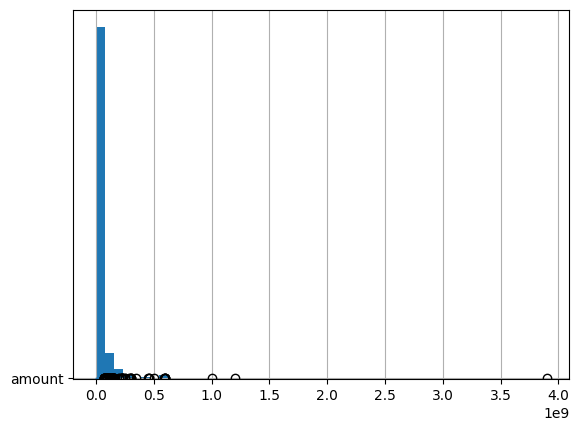

In [80]:
df['amount'].hist(bins=50)
df.boxplot(column='amount', vert=False)
df[df['is_outlier']].head()